## **Exercise 3**

In [1]:
import numpy as np
import spacy
import requests
import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_recall_curve, auc, precision_recall_fscore_support
from tensorflow.keras.layers import Embedding, Flatten, Dense, Add, Dropout, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, concatenate, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from keras.callbacks import ModelCheckpoint


# Load the spaCy model with pre-trained word embeddings
word_embeddings = spacy.load("en_core_web_sm")

def download_and_read_data(file_url, size):
    response = requests.get(file_url)
    lines = response.text.splitlines()
    sentences = []
    current_sentence = []

    for line in lines:
        if line.startswith('#') or line == '':
            if current_sentence:
                sentences.append(current_sentence)
                current_sentence = []
                if(len(sentences) == size):
                    break
        else:
            parts = line.split('\t')
            if len(parts) > 3:
                current_sentence.append((parts[1], parts[3]))  # (word, pos_tag)
    return sentences if not current_sentence else sentences + [current_sentence]

# URLs
train_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu"
dev_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu"
test_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"

# Read and preprocess data
subset_size = 1000
train_data = download_and_read_data(train_url, subset_size)
dev_data = download_and_read_data(dev_url, int(subset_size/5))
test_data = download_and_read_data(test_url, int(subset_size/5))

# Extract words and POS tags
def extract_features(sentence, i):
    word = sentence[i][0]
    pos = sentence[i][1]
    return [word], pos

# Create training, development, and test datasets
def create_dataset(data):
    X, y = [], []
    for sentence in data:
        for i in range(len(sentence)):
            features, pos = extract_features(sentence, i)
            X.append(features)
            y.append(pos)
    return X, y


X_train, y_train = create_dataset(train_data)
X_dev, y_dev = create_dataset(dev_data)
X_test, y_test = create_dataset(test_data)


X_train_embed = []
X_dev_embed = []
X_test_embed = []

# Convert words to spaCy word vectors
for dataset, X_embed in zip([X_train, X_dev, X_test], [X_train_embed, X_dev_embed, X_test_embed]):
    for sentence in tqdm.tqdm(range(len(dataset))):
        word_vectors = [word_embeddings(word).vector for word in dataset[sentence]]
        X_embed.append(np.array(word_vectors))


# Encode POS tags
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
num_classes = len(label_encoder.classes_)

y_train_encoded = label_encoder.transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)
y_test_encoded = label_encoder.transform(y_test)


# Convert tags to one-hot encoding
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_dev_onehot = to_categorical(y_dev_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

# constants
embedding_dim = word_embeddings('test').vector.shape[0]


# statistics
print("Training set size:", len(train_data))
print("Development set size:", len(dev_data))
print("Test set size:", len(test_data))
lengths = [len(i) for i in train_data] + [len(i) for i in dev_data] + [len(i) for i in test_data]
print("Average sentence length: ", sum(lengths)/len(lengths))
words_set = set()
for sentences in zip([train_data, dev_data, test_data]):
    for sent in sentences:
        for w in sent:
            words_set.add(w[0])
print("Number of words: ", len(words_set))
print("Vocabulary size: ", len(word_embeddings.vocab))

del word_embeddings
del train_data, X_train, y_train, y_train_encoded
del dev_data, X_dev, y_dev, y_dev_encoded
del test_data, X_test, y_test, y_test_encoded

100%|██████████| 4321/4321 [00:21<00:00, 199.09it/s]

Training set size: 1000
Development set size: 200
Test set size: 200
Average sentence length:  21.79
Number of words:  492
Vocabulary size:  6430


## **Find best hyperparameters**

In [ ]:
def evaluate_model(num_filters, dropout_rate, lr, epochs, stacked_l):
  with tf.device('/device:GPU:0'):
    inputs = Input(shape=(1,embedding_dim), dtype="float32")
    dropped_embeddings = Dropout(rate=dropout_rate)(inputs)

    pooled_convs = []
    filter_sizes = [2,3,4]

    for n_gram in filter_sizes:
        # n-gram convolutions with padding
        convs = Conv1D(filters=num_filters, kernel_size=n_gram, strides=1,
                      padding="same", activation='relu',
                      name='{}-gram_Convolutions'.format(n_gram))(dropped_embeddings)

        pooled_convs.append(GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(convs))

    concat = concatenate(pooled_convs)
    concat = Dropout(rate=dropout_rate)(concat)

    embedding_layer_conv = Conv1D(filters=3*num_filters, kernel_size=1, activation='linear', padding='same')(inputs)
    residual = Add()([concat, embedding_layer_conv])

    for n in range(stacked_l-1):
      pooled_convs = []

      for n_gram in filter_sizes:
          # n-gram convolutions with padding
          convs = Conv1D(filters=num_filters, kernel_size=n_gram, strides=1,
                        padding="same", activation='relu',
                        name='{}_{}-gram_Convolutions'.format(n, n_gram))(residual)

          pooled_convs.append(GlobalMaxPooling1D(name='{}_{}-gram_MaxPool'.format(n+1, n_gram))(convs))

      concat = concatenate(pooled_convs)
      concat = Dropout(rate=dropout_rate)(concat)
      residual = Add()([concat, residual])

    residual = Flatten()(residual)
    outputs = Dense(num_classes, activation='softmax')(residual)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    filepath = 'temp_best_model.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',
                                verbose=0, save_best_only=True, mode='min')
    callbacks = [checkpoint]

    history = model.fit(np.array(X_train_embed, dtype='float32'), y_train_onehot, epochs=epochs,
                        validation_data=(np.array(X_dev_embed, dtype='float32'), y_dev_onehot),
                        callbacks=callbacks, batch_size=32, verbose=0)

  loss, accuracy = model.evaluate(np.array(X_dev_embed), y_dev_onehot)

  del inputs, dropped_embeddings, pooled_convs, concat, embedding_layer_conv
  del residual, outputs, model, checkpoint, callbacks, history

  return accuracy, loss

def tune_hyperparam(params):
  best_acc = 0
  best_loss = 100
  best_params = ()
  for ftu in params["filter_units"]:
    for dro in params["dropout_rate"]:
      for lr in params["learning_rate"]:
        for ep in params["epochs"]:
          for sl in params["stacked_layers"]:
            print("Dev accuracy for params: ", (ftu, dro, lr, ep, sl))
            acc, loss = evaluate_model(ftu, dro, lr, ep, sl)
            if loss < best_loss or (loss == best_loss and acc > best_acc):
              best_acc = acc
              best_loss = loss
              best_params = (ftu, dro, lr, ep, sl)

  return best_acc, best_loss, best_params

In [ ]:
hyper_parameters = {
    "filter_units": [64],
    "dropout_rate": [0.2, 0.4, 0.6],
    "learning_rate": [0.0001, 0.001, 0.01],
    "epochs": [50],
    "stacked_layers": [3, 4, 5]
}

print(tune_hyperparam(hyper_parameters))

Dev accuracy for params:  (64, 0.2, 0.0001, 50, 3)
128/128 [==============================] - 0s 4ms/step - loss: 0.2679 - accuracy: 0.8999
Dev accuracy for params:  (64, 0.2, 0.0001, 50, 4)
128/128 [==============================] - 1s 5ms/step - loss: 0.2660 - accuracy: 0.9100
Dev accuracy for params:  (64, 0.2, 0.0001, 50, 5)
128/128 [==============================] - 1s 4ms/step - loss: 0.2688 - accuracy: 0.9100
Dev accuracy for params:  (64, 0.2, 0.001, 50, 3)
128/128 [==============================] - 0s 3ms/step - loss: 0.3052 - accuracy: 0.9024
Dev accuracy for params:  (64, 0.2, 0.001, 50, 4)
128/128 [==============================] - 1s 4ms/step - loss: 0.3073 - accuracy: 0.8957
Dev accuracy for params:  (64, 0.2, 0.001, 50, 5)
128/128 [==============================] - 1s 4ms/step - loss: 0.3119 - accuracy: 0.9014
Dev accuracy for params:  (64, 0.2, 0.01, 50, 3)
128/128 [==============================] - 0s 3ms/step - loss: 0.5876 - accuracy: 0.8883
Dev accuracy for params: 

In [ ]:
hyper_parameters = {
    "filter_units": [128],
    "dropout_rate": [0.2, 0.4, 0.6],
    "learning_rate": [0.0001, 0.001, 0.01],
    "epochs": [50],
    "stacked_layers": [3, 4, 5]
}

print(tune_hyperparam(hyper_parameters))

Dev accuracy for params:  (128, 0.2, 0.0001, 50, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


128/128 [==============================] - 1s 4ms/step - loss: 0.2769 - accuracy: 0.9090
Dev accuracy for params:  (128, 0.2, 0.0001, 50, 4)
128/128 [==============================] - 1s 5ms/step - loss: 0.2820 - accuracy: 0.9026
Dev accuracy for params:  (128, 0.2, 0.0001, 50, 5)
128/128 [==============================] - 1s 4ms/step - loss: 0.2882 - accuracy: 0.9083
Dev accuracy for params:  (128, 0.2, 0.001, 50, 3)
128/128 [==============================] - 1s 4ms/step - loss: 0.3253 - accuracy: 0.9048
Dev accuracy for params:  (128, 0.2, 0.001, 50, 4)
128/128 [==============================] - 1s 6ms/step - loss: 0.3134 - accuracy: 0.9070
Dev accuracy for params:  (128, 0.2, 0.001, 50, 5)
128/128 [==============================] - 1s 5ms/step - loss: 0.3394 - accuracy: 0.9024
Dev accuracy for params:  (128, 0.2, 0.01, 50, 3)
128/128 [==============================] - 0s 4ms/step - loss: 1.5212 - accuracy: 0.8574
Dev accuracy for params:  (128, 0.2, 0.01, 50, 4)
128/128 [===========

In [ ]:
hyper_parameters = {
    "filter_units": [256],
    "dropout_rate": [0.2, 0.4, 0.6],
    "learning_rate": [0.0001, 0.001, 0.01],
    "epochs": [50],
    "stacked_layers": [3, 4, 5]
}

print(tune_hyperparam(hyper_parameters))

Dev accuracy for params:  (256, 0.2, 0.0001, 50, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


128/128 [==============================] - 1s 5ms/step - loss: 0.2980 - accuracy: 0.9019
Dev accuracy for params:  (256, 0.2, 0.0001, 50, 4)
128/128 [==============================] - 1s 4ms/step - loss: 0.3023 - accuracy: 0.8947
Dev accuracy for params:  (256, 0.2, 0.0001, 50, 5)
128/128 [==============================] - 1s 6ms/step - loss: 0.3196 - accuracy: 0.9063
Dev accuracy for params:  (256, 0.2, 0.001, 50, 3)
128/128 [==============================] - 1s 5ms/step - loss: 0.3255 - accuracy: 0.8992
Dev accuracy for params:  (256, 0.2, 0.001, 50, 4)
128/128 [==============================] - 1s 4ms/step - loss: 0.3458 - accuracy: 0.9019
Dev accuracy for params:  (256, 0.2, 0.001, 50, 5)
128/128 [==============================] - 1s 6ms/step - loss: 0.3748 - accuracy: 0.9019
Dev accuracy for params:  (256, 0.2, 0.01, 50, 3)
128/128 [==============================] - 1s 5ms/step - loss: 3.9898 - accuracy: 0.8886
Dev accuracy for params:  (256, 0.2, 0.01, 50, 4)
128/128 [===========

## **Build model**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 96)]              0         []                            
                                                                                                  
 dropout (Dropout)           (None, 1, 96)                0         ['input_1[0][0]']             
                                                                                                  
 2-gram_Convolutions (Conv1  (None, 1, 64)                12352     ['dropout[0][0]']             
 D)                                                                                               
                                                                                                  
 3-gram_Convolutions (Conv1  (None, 1, 64)                18496     ['dropout[0][0]']         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


690/692 [============================>.] - ETA: 0s - loss: 0.7287 - accuracy: 0.8287
Epoch 2: val_loss improved from 0.49004 to 0.44920, saving model to best_model.hdf5
692/692 [==============================] - 14s 20ms/step - loss: 0.7287 - accuracy: 0.8287 - val_loss: 0.4492 - val_accuracy: 0.8967
Epoch 3/100
692/692 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.8490
Epoch 3: val_loss improved from 0.44920 to 0.40302, saving model to best_model.hdf5
692/692 [==============================] - 13s 19ms/step - loss: 0.6227 - accuracy: 0.8490 - val_loss: 0.4030 - val_accuracy: 0.9026
Epoch 4/100
691/692 [============================>.] - ETA: 0s - loss: 0.5509 - accuracy: 0.8622
Epoch 4: val_loss improved from 0.40302 to 0.36010, saving model to best_model.hdf5
692/692 [==============================] - 13s 19ms/step - loss: 0.5510 - accuracy: 0.8622 - val_loss: 0.3601 - val_accuracy: 0.9051
Epoch 5/100
692/692 [==============================] - ETA: 0s - loss:

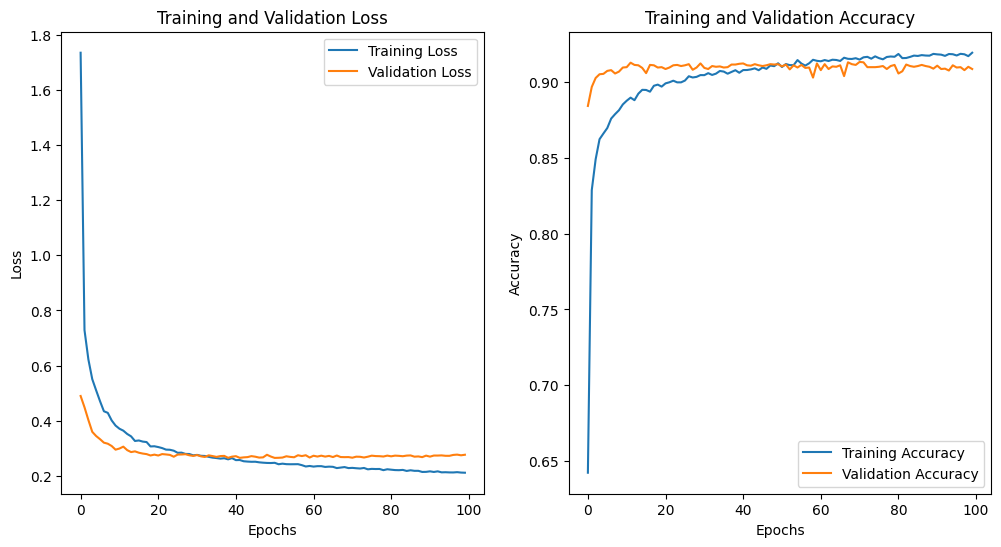

In [2]:
# Build the CNN model 64, 0.4, 0.0001, 50, 4
dropout_rate = 0.4
epochs = 100
learn_rate = 0.0001
num_layers = 4
num_filters = 64

with tf.device('/device:GPU:0'):
  inputs = Input(shape=(1,embedding_dim), dtype="float32")
  dropped_embeddings = Dropout(rate=dropout_rate)(inputs)

  pooled_convs = []
  filter_sizes = [2,3,4]

  for n_gram in filter_sizes:
      # n-gram convolutions with padding
      convs = Conv1D(filters=num_filters, kernel_size=n_gram, strides=1,
                    padding="same", activation='relu',
                    name='{}-gram_Convolutions'.format(n_gram))(dropped_embeddings)
      convs = BatchNormalization()(convs)
      pooled_convs.append(GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(convs))

  concat = concatenate(pooled_convs)
  concat = Dropout(rate=dropout_rate)(concat)

  embedding_layer_conv = Conv1D(filters=3*num_filters, kernel_size=1, activation='linear', padding='same')(inputs)
  residual = Add()([concat, embedding_layer_conv])

  for n in range(num_layers-1):
    pooled_convs = []

    for n_gram in filter_sizes:
        # n-gram convolutions with padding
        convs = Conv1D(filters=num_filters, kernel_size=n_gram, strides=1,
                      padding="same", activation='relu',
                      name='{}_{}-gram_Convolutions'.format(n, n_gram))(residual)
        convs = BatchNormalization()(convs)
        pooled_convs.append(GlobalMaxPooling1D(name='{}_{}-gram_MaxPool'.format(n+1, n_gram))(convs))

    concat = concatenate(pooled_convs)
    concat = Dropout(rate=dropout_rate)(concat)
    residual = Add()([concat, residual])

  residual = Flatten()(residual)
  outputs = Dense(num_classes, activation='softmax')(residual)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=Adam(learning_rate=learn_rate), loss='categorical_crossentropy', metrics=['accuracy'])

  print(model.summary())

  filepath = 'best_model.hdf5'
  checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',
                              verbose=1, save_best_only=True, mode='min')
  callbacks = [checkpoint]

  history = model.fit(np.array(X_train_embed, dtype='float32'), y_train_onehot, epochs=epochs,
                      validation_data=(np.array(X_dev_embed, dtype='float32'), y_dev_onehot),
                      callbacks=callbacks, batch_size=32)

loss_list = history.history['val_loss']
print("Min validation loss at epoch: ", loss_list.index(min(loss_list)), "->", min(loss_list))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(np.array(X_test_embed), y_test_onehot)
print(f'\nTest Accuracy: {accuracy * 100:.2f}%')

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **Calculate metrics**


Metrics for Training dataset:
692/692 [==============================] - 3s 3ms/step
             precision  recall f1-score  pr-auc  support
0               0.9067  0.9268   0.9167  0.9754     1626
1               0.8962  0.9057   0.9009  0.9494     2259
2               0.9377  0.8304   0.8808  0.9575      979
3               0.8843  0.9673   0.9239  0.9641     1193
4               0.9836     1.0   0.9917  0.9998      660
5               0.9742  0.9722   0.9732  0.9973     1942
6               0.9474  0.6667   0.7826  0.8602       27
7               0.9345  0.9324   0.9335  0.9821     3491
8               0.9543     1.0   0.9766  0.9977      313
9               0.7079  0.9844   0.8235  0.8795      576
10              0.9689  0.8954   0.9307  0.9868     1252
11              0.9525  0.9801   0.9661  0.9935     2311
12              0.9945  0.9996   0.9971  0.9998     2551
13              0.6667  0.6143   0.6394  0.6772      420
14                 0.9  0.4737   0.6207  0.6379       19
15

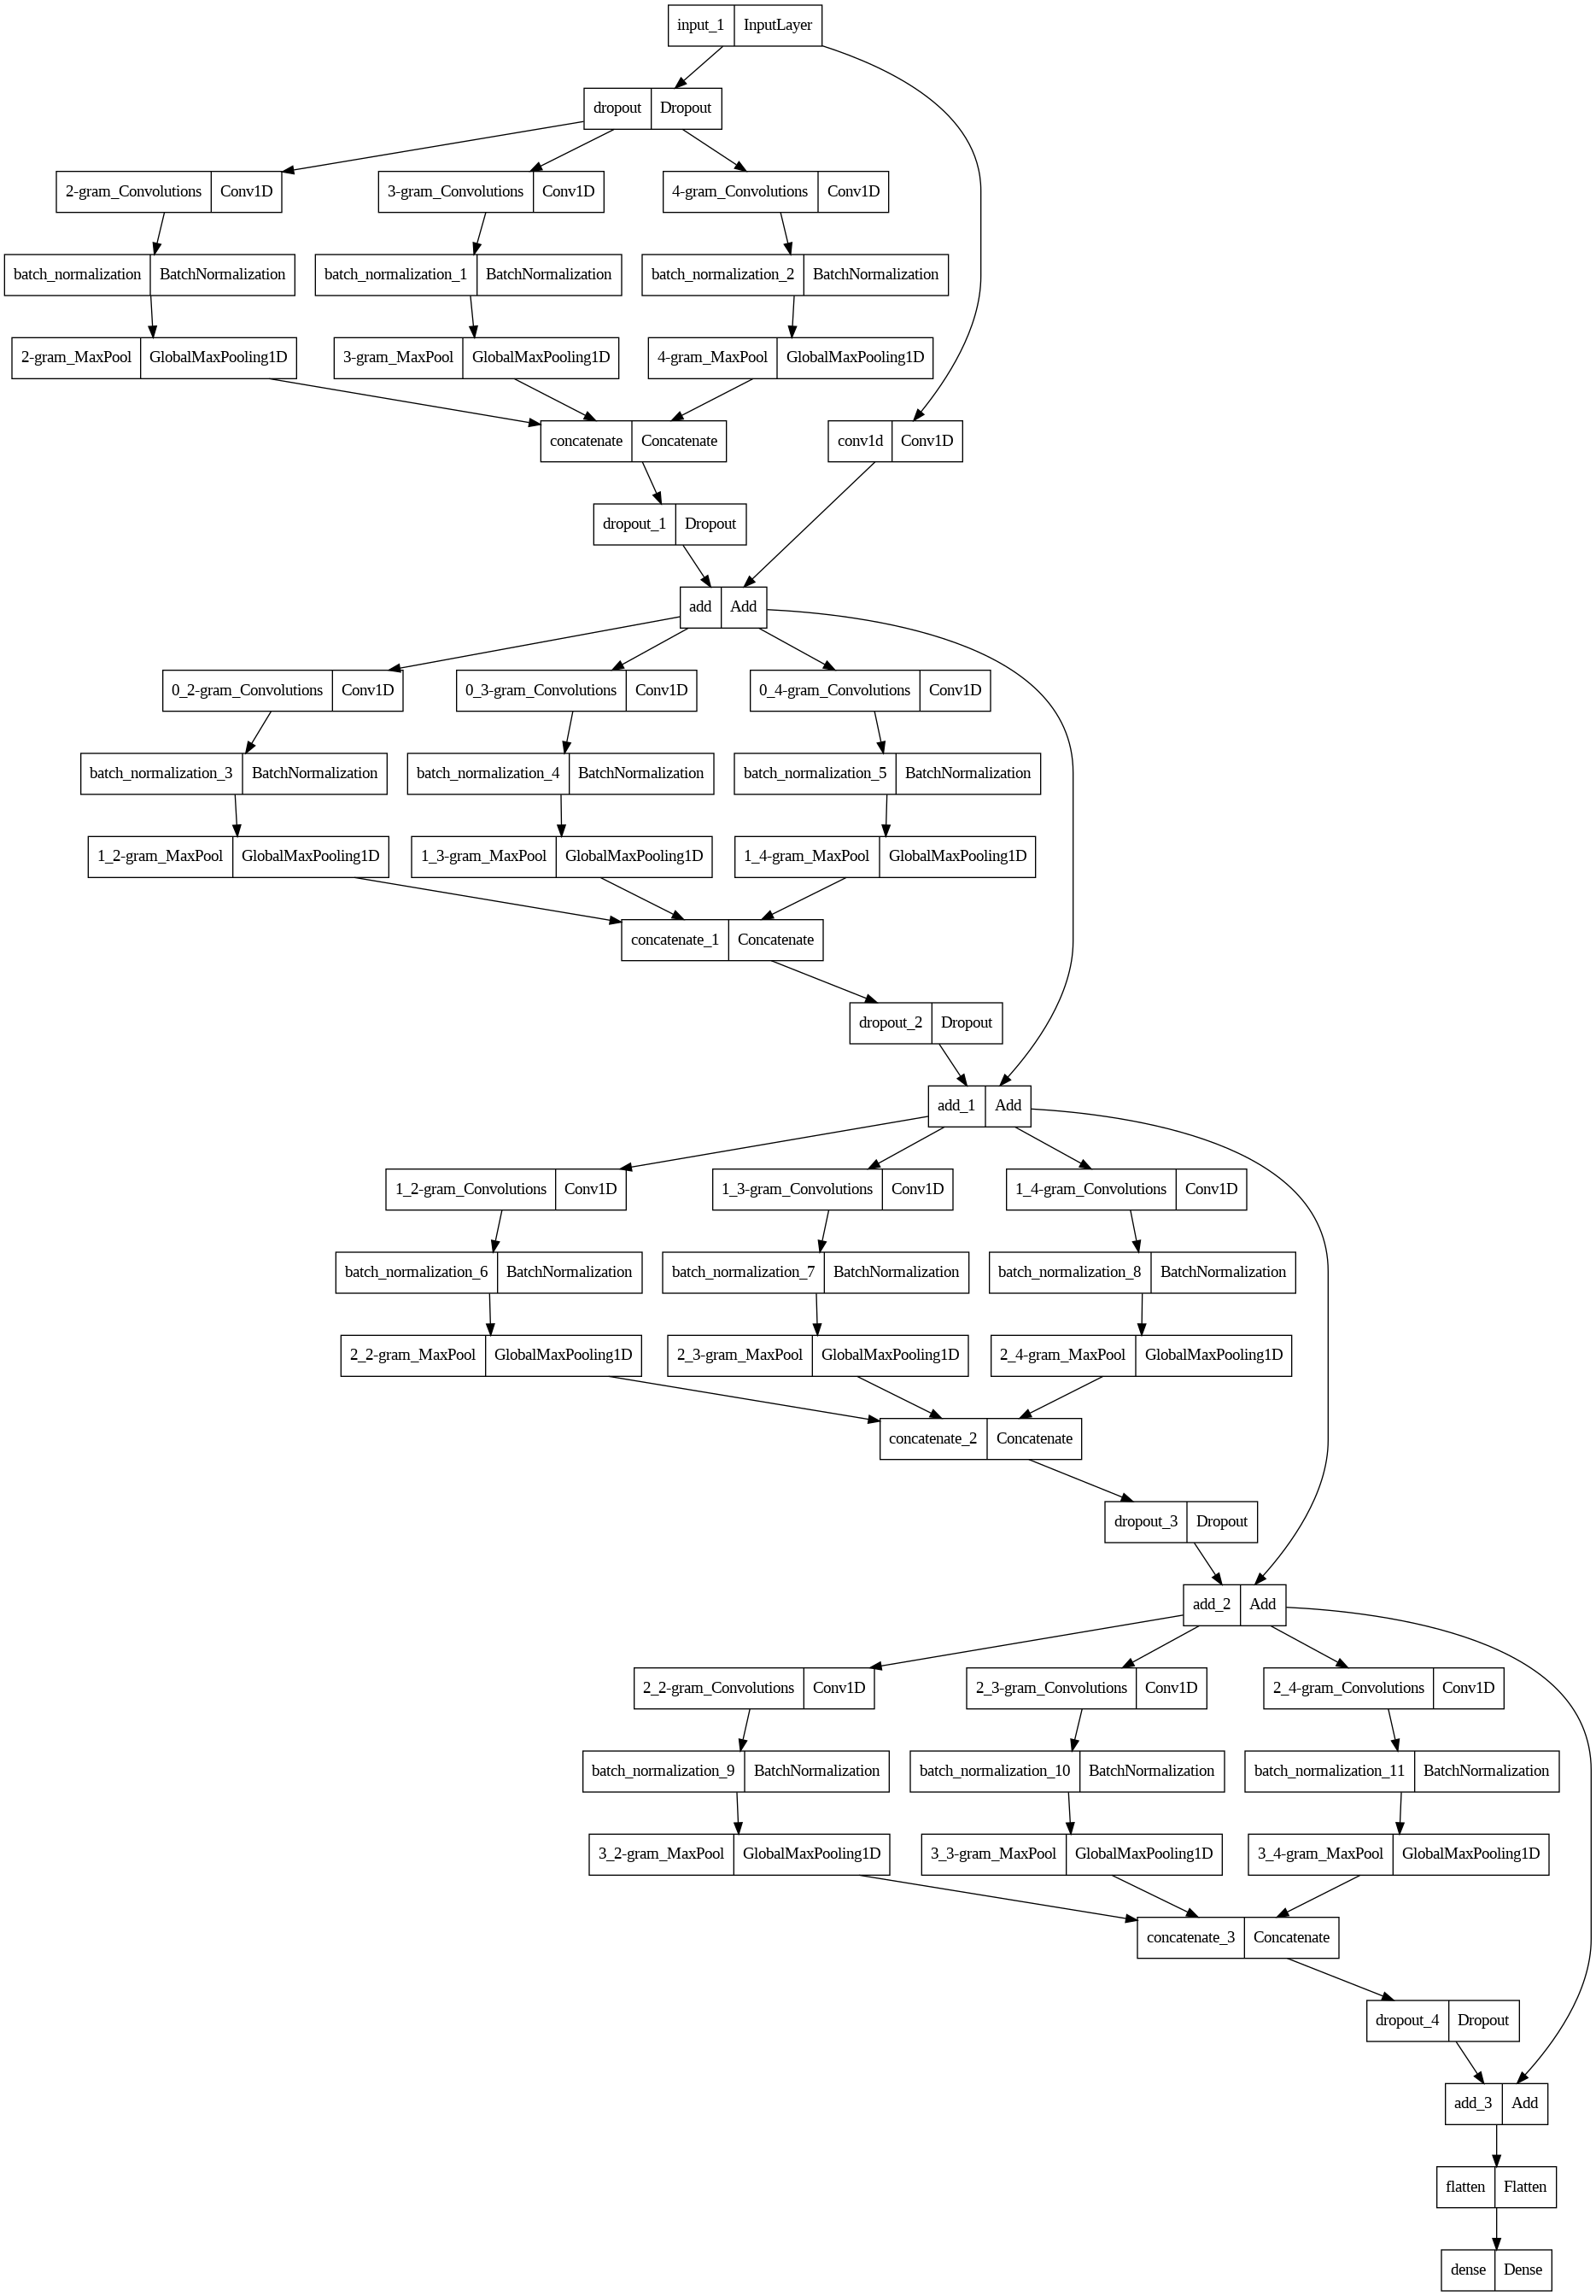

In [3]:
import pandas as pd


def calculate_metrics(custom_model, X, y):
  # X = X_test_embed, y = y_test_onehot
  y_pred_class = custom_model.predict(np.array(X))
  report = classification_report(np.argmax(y, axis=1), np.argmax(y_pred_class, axis=1), output_dict=True)
  n_classes = y.shape[1]

  # For each class
  for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y[:, i], y_pred_class[:, i])
    try:
      report[str(i)]["pr-auc"] = auc(recall, precision)
    except:
      report[str(i)] = {"precision": 0, "recall": 0, "f1-score": 0, "pr-auc": auc(recall, precision), "support": 0}

  # A "macro-average": quantifying score on all classes jointly
  precision, recall, _ = precision_recall_curve(y.ravel(), y_pred_class.ravel())
  report["macro avg"]["pr-auc"] = auc(recall, precision)
  report["accuracy"] = {"precision": '', "recall": '', "f1-score": report["accuracy"], "pr-auc": '', "support": 0}
  #del report["weighted avg"]

  pd.set_option('display.precision', 4)
  final_report = pd.DataFrame.from_dict(report).T
  final_report["support"] = final_report["support"].astype(int)
  final_report = final_report.reindex(columns=["precision", "recall", "f1-score", "pr-auc", "support"])
  return final_report


for name, X_set, y_set in zip(["Training", "Development", "Test"],
                              [X_train_embed, X_dev_embed, X_test_embed],
                              [y_train_onehot, y_dev_onehot, y_test_onehot]):
  print("\nMetrics for", name, "dataset:")
  print(calculate_metrics(model, X_set, y_set))


%matplotlib notebook

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image
Image('model.png')